Epoch 1000/10000, Loss: 1.6094301006734102
Epoch 2000/10000, Loss: 1.609351882317157
Epoch 3000/10000, Loss: 1.609190719759344
Epoch 4000/10000, Loss: 1.6087912534156656
Epoch 5000/10000, Loss: 1.6077687366987787
Epoch 6000/10000, Loss: 1.605140422484428
Epoch 7000/10000, Loss: 1.5983940010631503
Epoch 8000/10000, Loss: 1.5811718803040369
Epoch 9000/10000, Loss: 1.537842926690116
Epoch 10000/10000, Loss: 1.4329369347389413


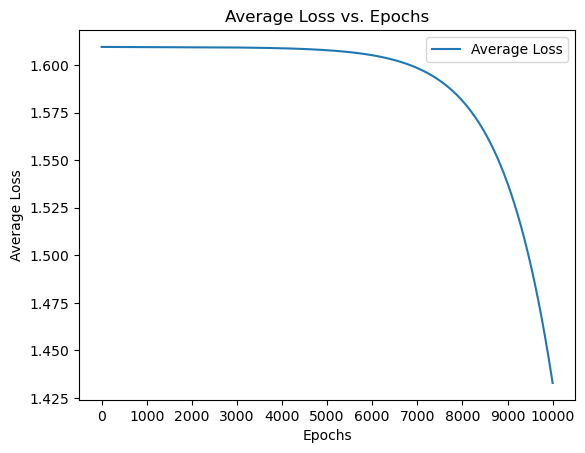

Probability of predicting 'stands' given context 'the man under the tree': 0.19213956305947608


In [6]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

class CBOW:
    def __init__(self, vocab_size, word_index, reverse_word_index, embedding_dim, hidden_dim, learning_rate=0.001):
        np.random.seed(42)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.word_index = word_index
        self.reverse_word_index = reverse_word_index
        # Initialize weights randomly
        self.W1 = np.random.randn(vocab_size, hidden_dim) * 0.01
        self.W2 = np.random.randn(hidden_dim, vocab_size) * 0.01

    def generate_one_hot(self, word_idx):
        one_hot = np.zeros(self.vocab_size)
        one_hot[int(word_idx)] = 1
        return one_hot

    def linear_activation(self, x):
        return x

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum(axis=0)

    def forward_pass(self, context):
        hidden_input = np.dot(self.W1.T, context)
        h = self.linear_activation(hidden_input)
        u = np.dot(self.W2.T, h)
        output_probs = self.softmax(u)
        return h, output_probs

    def backward_pass(self, context, target, h, output_probs):
        error_output = output_probs - target
        dW2 = np.outer(error_output, h)
        error_hidden = np.dot(self.W2, error_output)
        dW1 = np.outer(error_hidden, context)
        return dW1.T, dW2.T

    def update_weights(self, dW1, dW2):
        self.W1 -= self.learning_rate * dW1
        self.W2 -= self.learning_rate * dW2

    def train(self, corpus, epochs=1):
        losses = []
        for epoch in range(epochs):
            total_loss = 0.0
            for sentence in corpus:
                context_words = sentence.split()[:-1]
                target_word = sentence.split()[-1]

                context_vectors = [self.generate_one_hot(self.reverse_word_index[word]) for word in context_words]
                context = np.mean(context_vectors, axis=0)
                target = self.generate_one_hot(self.reverse_word_index[target_word])
                h, output_probs = self.forward_pass(context)
                j_star = int(target.argmax())

                # Calculate cross-entropy loss
                loss = -np.log(output_probs[j_star])  # E = - ln(y)
                total_loss += loss

                dW1, dW2 = self.backward_pass(context, target, h, output_probs)
                self.update_weights(dW1, dW2)

            average_loss = total_loss / len(corpus)
            losses.append(average_loss)

            # Optional: Print loss for every 1000 epochs
            if (epoch + 1) % 1000 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss}")

        plt.plot(range(1, epochs + 1), losses, label='Average Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Average Loss')
        plt.title('Average Loss vs. Epochs')
        plt.xticks(range(0, epochs + 1, 1000))  # Set x-axis ticks to be divisible by 1000
        plt.legend()
        plt.show()

    def predict(self, context_words, target_word):
        context_vectors = [self.generate_one_hot(self.reverse_word_index[word]) for word in context_words]
        context = np.mean(context_vectors, axis=0)
        _, output_probs = self.forward_pass(context)
        
        if target_word in self.reverse_word_index:
            target_idx = self.reverse_word_index[target_word]
            probability = output_probs[int(target_idx)]
            return probability
        else:
            return "Word not in vocabulary"

# Sample corpus with new sentence
corpus = [
    "the man stands under the tree",
   
    
]

epochs = 10000
text_corpus = ' '.join(corpus)

# Tokenize the text into words
words = text_corpus.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Sort words by their counts in descending order
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)

# Create a dictionary with unique words and assign an index
word_index = {str(i): word for i, word in enumerate(sorted_words)}
reverse_word_index = {value: key for key, value in word_index.items()}

vocab_size = len(word_counts)
embedding_dim = vocab_size
hidden_dim = 3

# Initialize CBOW model
cbow = CBOW(vocab_size, word_index, reverse_word_index, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

# Train the model
cbow.train(corpus, epochs)

# Predict probability of the target word 'stands' based on context
context_words = ["the", "man", "under", "the", "tree"]
target_word = "stands"
probability = cbow.predict(context_words, target_word)
print(f"Probability of predicting '{target_word}' given context '{' '.join(context_words)}': {probability}")


In [7]:
# Define the context
context_words = ["the", "man", "under", "the", "tree"]

# Convert context words to one-hot vectors
context_vectors = [cbow.generate_one_hot(cbow.reverse_word_index[word]) for word in context_words if word in cbow.reverse_word_index]
context = np.mean(context_vectors, axis=0)

# Get output probabilities from the CBOW model
_, output_probs = cbow.forward_pass(context)

# Get the index of the top probabilities
top_indices = np.argsort(output_probs)[-5:][::-1]  # Top 5 words for example

# Map indices to words and display probabilities
predicted_words = [(cbow.word_index[str(i)], output_probs[i]) for i in top_indices]
for word, prob in predicted_words:
    print(f"Word: {word}, Probability: {prob}")


Word: tree, Probability: 0.2329819903330405
Word: stands, Probability: 0.19213956305947608
Word: under, Probability: 0.19194793403612206
Word: man, Probability: 0.19156793771692596
Word: the, Probability: 0.19136257485443534
